In [1]:
# Meng-install library yang dibutuhkan untuk eksperimen
# transformers  : library Hugging Face untuk model Transformer (BERT, IndoBERT, MiniLM, dll)
# datasets      : library Hugging Face untuk pengelolaan dataset dan integrasi dengan Trainer
# scikit-learn  : library machine learning untuk evaluasi (accuracy, precision, recall, F1, ROC-AUC, K-Fold)
# torch         : PyTorch, framework deep learning yang digunakan untuk training model dan GPU acceleration
# -q            : quiet mode, agar output instalasi tidak terlalu panjang

!pip -q install transformers datasets scikit-learn torch

In [2]:
import json
# Library bawaan Python untuk membaca dan menulis data berformat JSON
# Digunakan untuk memuat dataset chatbot dari file .json

import numpy as np
# Library numerik untuk operasi array dan perhitungan matematis
# Digunakan untuk softmax, mean, std, dan manipulasi array prediksi

from pathlib import Path
# Digunakan untuk menangani path file secara aman dan portable

import os
# Library bawaan Python untuk operasi sistem (cek folder, hapus file, dll.)
# Digunakan saat menyimpan model terbaik dari cross-validation

import torch
# Framework deep learning PyTorch
# Digunakan sebagai backend training model Transformer dan GPU acceleration

import torch.nn.functional as F
# Modul fungsi neural network PyTorch
# Digunakan untuk softmax saat inferensi (prediksi confidence)

from sklearn.model_selection import StratifiedKFold
# Digunakan untuk melakukan Stratified K-Fold Cross-Validation
# Stratified memastikan distribusi label di setiap fold tetap seimbang

from sklearn.preprocessing import LabelEncoder, label_binarize
# LabelEncoder: mengubah label intent (string) menjadi angka
# label_binarize: mengubah label menjadi format one-hot untuk ROC-AUC multi-class

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix
)
# accuracy_score                  : menghitung akurasi klasifikasi
# precision_recall_fscore_support : menghitung precision, recall, dan F1-score
# roc_auc_score                   : menghitung ROC-AUC untuk klasifikasi multi-kelas
# confusion_matrix                : menghasilkan confusion matrix

from datasets import Dataset
# Digunakan untuk membuat dataset Hugging Face
# Memudahkan tokenisasi batch dan integrasi dengan Trainer

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed
)
# AutoTokenizer                    : memuat tokenizer sesuai model secara otomatis
# AutoModelForSequenceClassification: model Transformer untuk klasifikasi intent
# DataCollatorWithPadding          : melakukan padding dinamis per batch
# TrainingArguments                : konfigurasi proses training
# Trainer                          : API training tingkat tinggi dari Hugging Face
# set_seed                         : mengatur seed agar eksperimen reproducible

SEED = 42
# Seed random untuk memastikan hasil eksperimen konsisten (reproducibility)

K_FOLDS = 5
# Jumlah fold untuk Stratified K-Fold Cross-Validation

MODEL_NAME = "microsoft/Multilingual-MiniLM-L12-H384"
# Nama model pretrained yang digunakan

DATA_PATH = "dataset_chatbot.json"
# Path menuju file dataset chatbot dalam format JSON

BEST_DIR = "./best_fold_model"
# Direktori untuk menyimpan model terbaik hasil cross-validation

LR = 3e-5
# Learning rate untuk optimizer AdamW
# Nilai umum yang stabil untuk fine-tuning model Transformer

BATCH_SIZE = 16
# Ukuran batch training
# Disesuaikan agar muat di GPU dan tetap stabil

EPOCHS = 30
# Jumlah epoch training
# Cukup besar untuk dataset kecil–menengah agar model konvergen

MAX_LENGTH = 64
# Panjang maksimum token input
# Kalimat lebih panjang akan dipotong (truncation)

set_seed(SEED)
# Mengatur seed untuk PyTorch, NumPy, dan library terkait
# Bertujuan agar hasil training dapat direproduksi


In [3]:
# Membaca isi file dataset (JSON) dari path DATA_PATH
# File dibaca sebagai teks (string) dengan encoding UTF-8
# json.loads digunakan untuk mengubah string JSON menjadi objek Python (list/dict)
raw = json.loads(Path(DATA_PATH).read_text(encoding="utf-8"))

# Menyiapkan dua list kosong:
# - texts   : untuk menyimpan pertanyaan (input model)
# - intents : untuk menyimpan label intent (kelas)
texts, intents = [], []

# Melakukan iterasi untuk setiap data (baris) dalam dataset
for row in raw:
    # Mengambil field "question" dari JSON
    # strip() menghapus spasi di awal dan akhir teks
    q = (row.get("question") or "").strip()

    # Mengambil field "intent" dari JSON
    it = (row.get("intent") or "").strip()
    # hanya data yang memiliki question DAN intent yang dimasukkan
    if q and it:
        texts.append(q)       # simpan pertanyaan ke list texts
        intents.append(it)    # simpan intent ke list intents

# Menampilkan jumlah total data valid yang digunakan
print("Total data:", len(texts))

# Menampilkan jumlah intent unik dalam dataset
# set(intents) digunakan untuk menghilangkan duplikasi label
print("Jumlah intent:", len(set(intents)))

# Menampilkan satu contoh pasangan (question -> intent)
# Berguna untuk sanity check apakah data sudah benar
print("Contoh:", texts[0], "->", intents[0])

# Membuat objek LabelEncoder dari scikit-learn
# Digunakan untuk mengubah label intent (string) menjadi angka
le = LabelEncoder()

# Mengubah semua intent (string) menjadi label numerik (0, 1, 2, ...)
y = le.fit_transform(intents)

# Menghitung jumlah total kelas / intent
# le.classes_ berisi daftar intent unik yang telah di-encode
num_labels = len(le.classes_)

# Menampilkan jumlah kelas (akan digunakan saat inisialisasi model)
print("num_labels:", num_labels)


Total data: 2040
Jumlah intent: 204
Contoh: Bagaimana cara melihat data pribadi saya di sistem akademik Unpad? -> prosedur_akses_data_pribadi_mahasiswa
num_labels: 204


In [4]:
# Memuat tokenizer sesuai dengan model pretrained yang digunakan
# AutoTokenizer akan otomatis memilih jenis tokenizer yang tepat
# berdasarkan MODEL_NAME (misalnya BERT, ALBERT, MiniLM, dll.)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# DataCollatorWithPadding digunakan untuk melakukan padding secara dinamis
# Padding dilakukan berdasarkan panjang teks terpanjang di setiap batch
# Hal ini membuat training lebih efisien dibanding padding ke panjang maksimum
collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_fn(batch):
    """
    Fungsi untuk mengubah teks mentah menjadi token numerik
    yang dapat diproses oleh model Transformer.

    Parameter:
    - batch["text"]: kumpulan teks (pertanyaan) dalam satu batch

    Proses:
    - truncation=True  : memotong teks jika melebihi MAX_LENGTH
    - max_length       : batas maksimum jumlah token
    """
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH
    )

def softmax_np(logits):
    """
    Menghitung softmax menggunakan NumPy.

    Digunakan untuk mengubah nilai logit (skor mentah model)
    menjadi probabilitas kelas.

    logits: array dengan shape [n_samples, n_classes]
    """
    # Mengurangi nilai maksimum tiap baris untuk stabilitas numerik
    logits = logits - np.max(logits, axis=1, keepdims=True)

    # Menghitung eksponensial dari setiap nilai logit
    exp = np.exp(logits)

    # Membagi dengan total eksponensial untuk mendapatkan probabilitas
    return exp / np.sum(exp, axis=1, keepdims=True)


def compute_all_metrics(y_true, y_pred, y_proba, num_labels):
    """
    Menghitung berbagai metrik evaluasi untuk klasifikasi multi-kelas.

    Parameter:
    - y_true     : label asli (ground truth)
    - y_pred     : label hasil prediksi model
    - y_proba    : probabilitas hasil softmax
    - num_labels : jumlah total kelas / intent
    """

    # Menghitung akurasi klasifikasi
    acc = accuracy_score(y_true, y_pred)

    # Menghitung precision, recall, dan F1-score
    # average="macro" digunakan agar semua kelas diperlakukan setara
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0
    )

    # Mengubah label asli menjadi representasi one-hot
    # Diperlukan untuk perhitungan ROC-AUC multi-kelas
    y_true_oh = label_binarize(
        y_true,
        classes=list(range(num_labels))
    )

    # Menghitung ROC-AUC dengan pendekatan One-vs-Rest (OvR)
    # Try-except digunakan karena ROC-AUC bisa gagal jika
    # suatu fold tidak mengandung semua kelas
    try:
        auc = roc_auc_score(
            y_true_oh,
            y_proba,
            multi_class="ovr",
            average="macro"
        )
    except ValueError:
        auc = float("nan")

    # Menghitung confusion matrix
    # Baris = label sebenarnya, kolom = label prediksi
    cm = confusion_matrix(
        y_true,
        y_pred,
        labels=list(range(num_labels))
    )

    # Mengembalikan seluruh metrik dalam bentuk dictionary
    return {
        "accuracy": float(acc),
        "precision_macro": float(prec),
        "recall_macro": float(rec),
        "f1_macro": float(f1),
        "roc_auc_ovr_macro": float(auc),
        "confusion_matrix": cm,
    }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Membuat objek StratifiedKFold
# n_splits=K_FOLDS   : jumlah fold (misalnya 5-fold)
# shuffle=True       : data diacak sebelum dibagi
# random_state=SEED  : agar pembagian data konsisten (reproducible)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# List untuk menyimpan hasil evaluasi tiap fold (accuracy, precision, recall, f1, dll)
fold_results = []

# List untuk menyimpan confusion matrix dari tiap fold
conf_mats = []

# Variabel untuk menyimpan informasi fold terbaik
best_fold = None            # nomor fold terbaik
best_score = -1.0           # skor terbaik (pakai F1-macro)
best_metrics = None         # metrik dari fold terbaik

# Mengecek apakah folder BEST_DIR sudah ada
if os.path.isdir(BEST_DIR):
    # Menghapus seluruh isi folder BEST_DIR
    # Ini dilakukan agar model lama tidak tertimpa atau tercampur
    for root, dirs, files in os.walk(BEST_DIR, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))  # hapus file
        for name in dirs:
            os.rmdir(os.path.join(root, name))   # hapus subfolder
    os.rmdir(BEST_DIR)  # hapus folder utama

# Looping untuk setiap fold
# skf.split(texts, y) akan menghasilkan index data train dan validation
for fold, (train_idx, val_idx) in enumerate(skf.split(texts, y), start=1):

    print(f"\n==================== FOLD {fold}/{K_FOLDS} ====================")

    # Menyusun data training berdasarkan index train_idx
    train_data = {
        "text":  [texts[i] for i in train_idx],  # pertanyaan untuk training
        "label": [int(y[i]) for i in train_idx]  # label intent untuk training
    }

    # Menyusun data validasi berdasarkan index val_idx
    val_data = {
        "text":  [texts[i] for i in val_idx],     # pertanyaan untuk validasi
        "label": [int(y[i]) for i in val_idx]     # label intent untuk validasi
    }

    # Mengubah dictionary menjadi Hugging Face Dataset
    # lalu melakukan tokenisasi secara batch
    ds_train = Dataset.from_dict(train_data).map(tokenize_fn, batched=True)
    ds_val   = Dataset.from_dict(val_data).map(tokenize_fn, batched=True)

    # Menghapus kolom "text" karena model hanya butuh input_ids & attention_mask
    # with_format("torch") agar output berupa tensor PyTorch
    ds_train = ds_train.remove_columns(["text"]).with_format("torch")
    ds_val   = ds_val.remove_columns(["text"]).with_format("torch")

    # Model selalu dibuat ulang di setiap fold
    # Ini penting agar tidak terjadi kebocoran informasi antar fold
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels
    )

    # Konfigurasi training
    args = TrainingArguments(
        output_dir=f"./cv_runs/fold_{fold}",   # folder output khusus fold ini
        learning_rate=LR,                      # learning rate
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,               # jumlah epoch
        weight_decay=0.01,                     # regularisasi
        logging_steps=50,                      # interval logging
        report_to="none",                      # tidak pakai wandb/tensorboard
        seed=SEED,
        fp16=torch.cuda.is_available(),        # pakai FP16 jika ada GPU
    )

    # Membuat Trainer (API training Hugging Face)
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        tokenizer=tokenizer,
        data_collator=collator,
    )

    # TRAINING MODEL PADA FOLD INI
    trainer.train()

    # Melakukan prediksi pada data validasi
    out = trainer.predict(ds_val)

    # Logits = skor mentah model (belum softmax)
    logits = out.predictions

    # Label asli (ground truth)
    y_true = out.label_ids.astype(int)

    # Mengubah logits menjadi probabilitas
    y_proba = softmax_np(logits)

    # Mengambil kelas dengan probabilitas tertinggi
    y_pred = np.argmax(y_proba, axis=1)

    # Menghitung seluruh metrik evaluasi
    metrics = compute_all_metrics(y_true, y_pred, y_proba, num_labels)

    # Mengambil confusion matrix
    cm = metrics["confusion_matrix"]

    # Menyimpan metrik (tanpa confusion matrix agar ringkas)
    fold_row = {k: v for k, v in metrics.items() if k != "confusion_matrix"}
    fold_row["fold"] = fold

    fold_results.append(fold_row)
    conf_mats.append(cm)

    print("Fold metrics:", fold_row)

    # ======================
    # MENENTUKAN FOLD TERBAIK
    # ======================

    # Jika F1-macro fold ini lebih baik dari sebelumnya
    if fold_row["f1_macro"] > best_score:
        best_score = fold_row["f1_macro"]
        best_fold = fold
        best_metrics = fold_row

        # Membuat folder untuk menyimpan model terbaik
        os.makedirs(BEST_DIR, exist_ok=True)

        # Menyimpan model dan tokenizer dari fold terbaik
        trainer.save_model(BEST_DIR)
        tokenizer.save_pretrained(BEST_DIR)

        # Menyimpan mapping label index -> intent
        with open(os.path.join(BEST_DIR, "label_names.json"), "w", encoding="utf-8") as f:
            json.dump(le.classes_.tolist(), f, ensure_ascii=False, indent=2)
        print(
            f"✅ Best model updated: "
            f"fold={best_fold}, best_f1={best_score:.4f} -> saved to {BEST_DIR}"
        )

# ======================
# RINGKASAN FOLD TERBAIK
# ======================

print("\n==================== BEST FOLD ====================")
print("Best fold:", best_fold)
print("Best metrics:", best_metrics)


==================== FOLD 1/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3330309801.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Step,Training Loss
50,5.321400
100,5.321500
150,5.298300
200,5.252000
250,5.186900
300,5.131500
350,5.068200
400,5.013200
450,4.955300
500,4.905800


Fold metrics: {'accuracy': 0.5563725490196079, 'precision_macro': 0.49525881653909337, 'recall_macro': 0.5563725490196079, 'f1_macro': 0.4842474146653713, 'roc_auc_ovr_macro': 0.9899425287356322, 'fold': 1}
✅ Best model updated: fold=1, best_f1=0.4842 -> saved to ./best_fold_model

==================== FOLD 2/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3330309801.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Step,Training Loss
50,5.320000
100,5.323200
150,5.303500
200,5.265500
250,5.192600
300,5.136700
350,5.062400
400,5.010800
450,4.946600
500,4.897300


Fold metrics: {'accuracy': 0.5514705882352942, 'precision_macro': 0.5265559331735803, 'recall_macro': 0.5514705882352942, 'f1_macro': 0.49730449289272816, 'roc_auc_ovr_macro': 0.9942287259731478, 'fold': 2}
✅ Best model updated: fold=2, best_f1=0.4973 -> saved to ./best_fold_model

==================== FOLD 3/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3330309801.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Step,Training Loss
50,5.320500
100,5.322700
150,5.302500
200,5.260800
250,5.188200
300,5.130400
350,5.065600
400,5.011800
450,4.946200
500,4.900700


Fold metrics: {'accuracy': 0.5514705882352942, 'precision_macro': 0.5020347027699968, 'recall_macro': 0.5514705882352942, 'f1_macro': 0.48965990436578666, 'roc_auc_ovr_macro': 0.9807422969187675, 'fold': 3}

==================== FOLD 4/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3330309801.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Step,Training Loss
50,5.320500
100,5.322500
150,5.304900
200,5.264800
250,5.190400
300,5.126500
350,5.053900
400,5.000300
450,4.931900
500,4.883200


Fold metrics: {'accuracy': 0.6299019607843137, 'precision_macro': 0.5751750700280113, 'recall_macro': 0.6299019607843137, 'f1_macro': 0.5653906006847182, 'roc_auc_ovr_macro': 0.9941562832029363, 'fold': 4}
✅ Best model updated: fold=4, best_f1=0.5654 -> saved to ./best_fold_model

==================== FOLD 5/5 ====================


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3330309801.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 0, 'pad_token_id': 1}.


Step,Training Loss
50,5.320300
100,5.323500
150,5.306400
200,5.269100
250,5.194700
300,5.135100
350,5.063400
400,5.008300
450,4.936500
500,4.895900


Fold metrics: {'accuracy': 0.5833333333333334, 'precision_macro': 0.5081915089268031, 'recall_macro': 0.5833333333333334, 'f1_macro': 0.5079451050039285, 'roc_auc_ovr_macro': 0.9921822177146721, 'fold': 5}

==================== BEST FOLD ====================
Best fold: 4
Best metrics: {'accuracy': 0.6299019607843137, 'precision_macro': 0.5751750700280113, 'recall_macro': 0.6299019607843137, 'f1_macro': 0.5653906006847182, 'roc_auc_ovr_macro': 0.9941562832029363, 'fold': 4}


In [6]:
# Fungsi untuk menghitung rata-rata dan standar deviasi
# np.nanmean / np.nanstd dipakai agar nilai NaN (misalnya dari ROC-AUC)
# tidak menyebabkan error pada perhitungan
def mean_std(xs):
    return float(np.nanmean(xs)), float(np.nanstd(xs))

# Mengambil nilai accuracy, precision, recall, dll dari setiap fold
accs  = [r["accuracy"] for r in fold_results]
precs = [r["precision_macro"] for r in fold_results]
recs  = [r["recall_macro"] for r in fold_results]
f1s   = [r["f1_macro"] for r in fold_results]
aucs  = [r["roc_auc_ovr_macro"] for r in fold_results]

# Menampilkan rata-rata ± standar deviasi untuk setiap metrik
print("\n==================== CV SUMMARY (K=5) ====================")
m, s = mean_std(accs);  print(f"Accuracy           : {m:.4f} ± {s:.4f}")
m, s = mean_std(precs); print(f"Precision (macro)  : {m:.4f} ± {s:.4f}")
m, s = mean_std(recs);  print(f"Recall (macro)     : {m:.4f} ± {s:.4f}")
m, s = mean_std(f1s);   print(f"F1-score (macro)   : {m:.4f} ± {s:.4f}")
m, s = mean_std(aucs);  print(f"ROC-AUC (OvR macro): {m:.4f} ± {s:.4f}")

# Menghitung confusion matrix rata-rata dari seluruh fold
cm_avg = np.mean(np.stack(conf_mats), axis=0)
print("\nConfusion matrix rata-rata shape:", cm_avg.shape)

# Menampilkan detail hasil evaluasi untuk setiap fold
print("\nDetail per fold:")
for r in fold_results:
    print(r)



==================== CV SUMMARY (K=5) ====================
Accuracy           : 0.5745 ± 0.0301
Precision (macro)  : 0.5214 ± 0.0288
Recall (macro)     : 0.5745 ± 0.0301
F1-score (macro)   : 0.5089 ± 0.0293
ROC-AUC (OvR macro): 0.9903 ± 0.0050

Confusion matrix rata-rata shape: (204, 204)

Detail per fold:
{'accuracy': 0.5563725490196079, 'precision_macro': 0.49525881653909337, 'recall_macro': 0.5563725490196079, 'f1_macro': 0.4842474146653713, 'roc_auc_ovr_macro': 0.9899425287356322, 'fold': 1}
{'accuracy': 0.5514705882352942, 'precision_macro': 0.5265559331735803, 'recall_macro': 0.5514705882352942, 'f1_macro': 0.49730449289272816, 'roc_auc_ovr_macro': 0.9942287259731478, 'fold': 2}
{'accuracy': 0.5514705882352942, 'precision_macro': 0.5020347027699968, 'recall_macro': 0.5514705882352942, 'f1_macro': 0.48965990436578666, 'roc_auc_ovr_macro': 0.9807422969187675, 'fold': 3}
{'accuracy': 0.6299019607843137, 'precision_macro': 0.5751750700280113, 'recall_macro': 0.6299019607843137, 'f1_

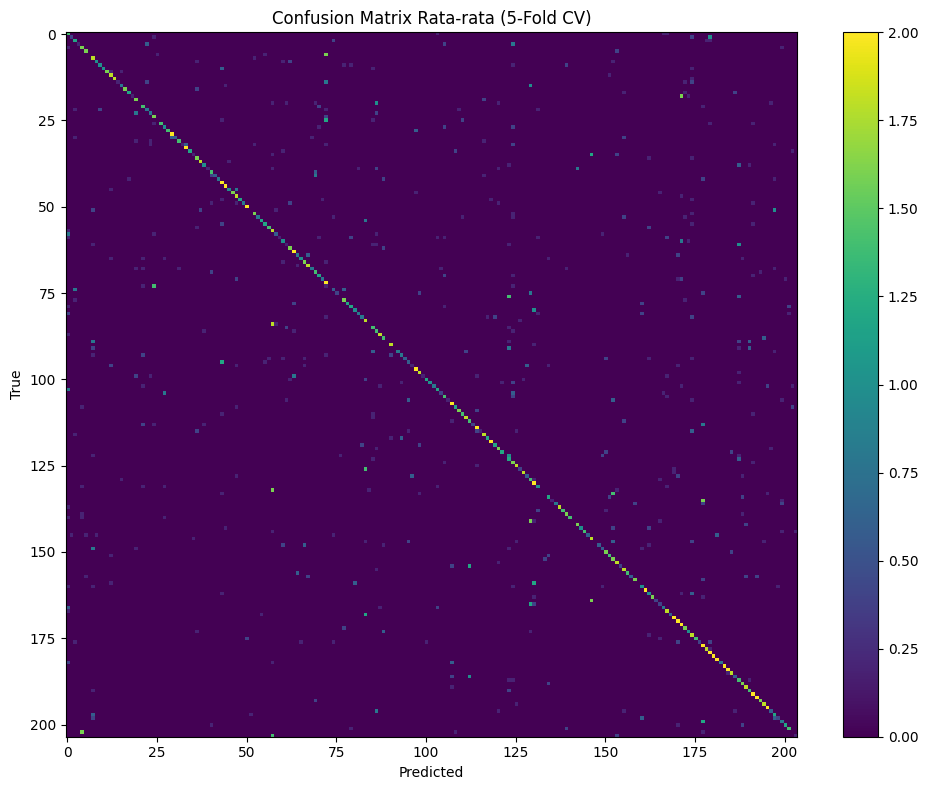

In [7]:
import matplotlib.pyplot as plt
# Import library matplotlib untuk visualisasi data (plot / grafik)

# Membuat figure (kanvas) dengan ukuran 10 x 8 inci
# Ukuran ini dipilih agar confusion matrix terlihat jelas
plt.figure(figsize=(10, 8))

# Menampilkan confusion matrix rata-rata sebagai gambar (heatmap)
# cm_avg berisi nilai confusion matrix hasil rata-rata 5-fold CV
# aspect="auto" agar skala sumbu menyesuaikan ukuran matriks
plt.imshow(cm_avg, aspect="auto")

# Menampilkan colorbar di samping gambar
# Colorbar menunjukkan intensitas warna (besar-kecilnya nilai)
plt.colorbar()

# Judul plot
plt.title("Confusion Matrix Rata-rata (5-Fold CV)")
# Label sumbu X (kolom) = kelas hasil prediksi model
plt.xlabel("Predicted")
# Label sumbu Y (baris) = kelas label sebenarnya (ground truth)
plt.ylabel("True")
# Mengatur layout agar tidak ada teks yang terpotong
plt.tight_layout()
# Menampilkan plot ke layar
plt.show()


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Import tokenizer dan model untuk inference (deploy)

# Menentukan device:
# - GPU (cuda) jika tersedia
# - CPU jika tidak ada GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memuat tokenizer yang disimpan dari fold terbaik
# Tokenizer ini HARUS sama dengan tokenizer saat training
deploy_tokenizer = AutoTokenizer.from_pretrained(BEST_DIR)

# Memuat model klasifikasi intent dari folder BEST_DIR
deploy_model = AutoModelForSequenceClassification.from_pretrained(BEST_DIR).to(device)

# Mengatur model ke mode evaluasi
# agar:
# - dropout dimatikan
# - hasil prediksi konsisten
deploy_model.eval()

# Membaca mapping index → nama intent
# File ini disimpan saat training
with open(os.path.join(BEST_DIR, "label_names.json"), "r", encoding="utf-8") as f:
    label_names = json.load(f)


def predict_topk(text, top_k=5):
    """
    Melakukan prediksi intent untuk satu input teks
    dan mengembalikan top-k intent dengan probabilitas tertinggi
    """

    # Tokenisasi input teks
    # return_tensors="pt" -> output berupa tensor PyTorch
    inputs = deploy_tokenizer(
        text,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

    # Memindahkan input ke device yang sama dengan model (CPU/GPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Menonaktifkan perhitungan gradien (hemat memori & lebih cepat)
    with torch.no_grad():
        # Forward pass model
        # logits = skor mentah untuk setiap intent
        logits = deploy_model(**inputs).logits

    # Mengubah logits menjadi probabilitas menggunakan softmax
    # squeeze(0) menghilangkan dimensi batch -> shape jadi [num_classes]
    probs = F.softmax(logits, dim=1).squeeze(0)

    # Mengambil top-k probabilitas terbesar
    # vals = nilai probabilitas
    # idxs = index kelas
    vals, idxs = torch.topk(probs, k=top_k)

    # Mengembalikan hasil dalam bentuk:
    # (nama_intent, probabilitas)
    return [(label_names[i], float(v)) for v, i in zip(vals.tolist(), idxs.tolist())]


# Contoh pertanyaan untuk pengujian chatbot
tests = [
    "Cara pinjam ruangan PPBS?",
    "Cara isi KRS?",
    "Gimana alur skripsi dari awal sampai selesai?",
    "Cara isi absen matkul?"
]

# Melakukan prediksi top-5 intent untuk setiap pertanyaan
for t in tests:
    print("\nQ:", t)
    for tag, p in predict_topk(t, top_k=5):
        print(f" - {tag}: {p:.4f}")


The tokenizer you are loading from './best_fold_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



Q: Cara pinjam ruangan PPBS?
 - prosedur_peminjaman_ruangan_ppbs: 0.0291
 - info_jadwal_pkrs: 0.0240
 - prosedur_pengajuan_seminar_tugas_akhir: 0.0202
 - info_lewat_batas_waktu_pkrs: 0.0191
 - info_jadwal_pengisian_krs: 0.0187

Q: Cara isi KRS?
 - prosedur_pengisian_krs: 0.0291
 - prosedur_konversi_sks_mbkm: 0.0283
 - prosedur_akses_cetak_kks: 0.0283
 - konsekuensi_keterlambatan_pengisian_krs: 0.0249
 - info_fungsi_staf_tu_program_studi: 0.0208

Q: Gimana alur skripsi dari awal sampai selesai?
 - info_prosedur_pelaksanaan_skripsi_sampai_wisuda: 0.0247
 - prosedur_pengurusan_surat_keterangan_aktif: 0.0242
 - prosedur_upload_tugas_akhir_repository: 0.0210
 - prosedur_akses_format_penulisan_skripsi_magang: 0.0201
 - info_repository_tugas_akhir: 0.0173

Q: Cara isi absen matkul?
 - prosedur_absensi_kuliah_pacis: 0.0298
 - prosedur_koreksi_absensi: 0.0289
 - prosedur_pengurusan_cetak_ulang_ijazah: 0.0252
 - info_jadwal_pembayaran_ukt_dan_her_registrasi: 0.0215
 - prosedur_pengajuan_legalis

In [9]:
import shutil

shutil.make_archive(
    "best_fold_model",  # nama file zip
    "zip",              # format zip
    BEST_DIR             # folder yang mau di-zip
)
from google.colab import files
files.download("best_fold_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>